In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinnull=pd.read_csv("..\..\..\datos\datos2\datos_clusterizados2_sin_nulos.csv", index_col=0)


In [3]:
df_sinnull.head(2)

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario
0,Second Class,Corporate,Wollongong,Australia,Furniture,Chairs,entre 9 y 10,0.10,Critical,February,390.46
1,Same Day,Consumer,Dakar,Senegal,Technology,Copiers,entre 7 y 8,0.00,Critical,November,377.73


In [4]:
df_sinnull.duplicated().sum()

0

In [5]:
df_sinnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37662 entries, 0 to 37661
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ship Mode       37662 non-null  object 
 1   Segment         37662 non-null  object 
 2   City            37662 non-null  object 
 3   Country         37662 non-null  object 
 4   Category        37662 non-null  object 
 5   Sub-Category    37662 non-null  object 
 6   Quantity        37662 non-null  object 
 7   Discount        37662 non-null  float64
 8   Order Priority  37662 non-null  object 
 9   month           37662 non-null  object 
 10  Sales_unitario  37662 non-null  float64
dtypes: float64(2), object(9)
memory usage: 3.4+ MB


Tenemos 9 columnas de categóricas

In [6]:
df_sinnull.nunique()

Ship Mode             4
Segment               3
City               3587
Country             145
Category              3
Sub-Category         17
Quantity              8
Discount             27
Order Priority        4
month                12
Sales_unitario    21140
dtype: int64

In [7]:
df_categoricas=df_sinnull.select_dtypes("O")

In [8]:
df_categoricas.head()

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Order Priority,month
0,Second Class,Corporate,Wollongong,Australia,Furniture,Chairs,entre 9 y 10,Critical,February
1,Same Day,Consumer,Dakar,Senegal,Technology,Copiers,entre 7 y 8,Critical,November
2,First Class,Consumer,Porirua,New Zealand,Furniture,Chairs,entre 3 y 4,Critical,November
3,Standard Class,Consumer,Hamilton,New Zealand,Furniture,Tables,entre 5 y 6,High,April
4,Standard Class,Corporate,Sacramento,United States,Office Supplies,Binders,entre 5 y 6,Low,October


Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

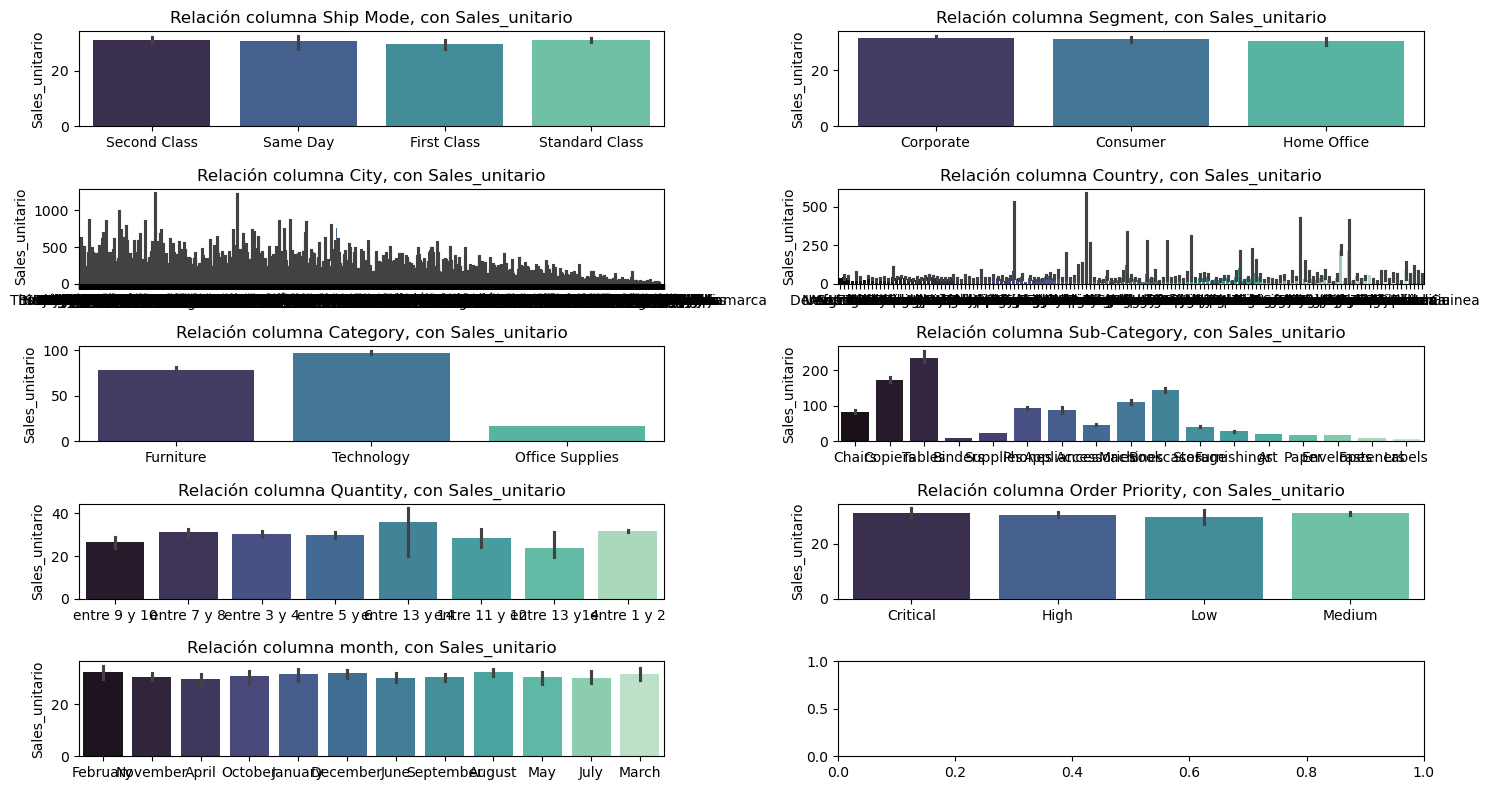

In [9]:
f.visualizar_categoricas(df_sinnull, "Sales_unitario", (15,8), tipo_graf="bar", bigote=1.5, metrica="median")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

In [ ]:
# llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinnull, columna_numerica= "Sales_unitario")
print("\n-------------\n")
lista_col_categ=df_sinnull.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinnull, "Sales_unitario", categoria)
    test.run_all_tests()
    print("\n###########################\n")

#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- SHIP MODE
- SEGMENT
- QUANTITY
- ORDER PRIORITY
- MONTH  
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- SUB-CATEGORY (entre casi todas)
- CITY  (entre algunas)
- COUNTRY (entre algunas)
- CATEGORY  (entre todas)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [11]:
df_sinnull.columns

Index(['Ship Mode', 'Segment', 'City', 'Country', 'Category', 'Sub-Category',
       'Quantity', 'Discount', 'Order Priority', 'month', 'Sales_unitario'],
      dtype='object')

In [12]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment','Quantity','Order Priority', 'month'], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ['City', 'Country','Category', 'Sub-Category']  
                        }

In [13]:
df_sinnull.shape

(37662, 11)

In [14]:
encoding=f.Encoding(dataframe = df_sinnull , diccionario_encoding= diccionario_encoding, variable_respuesta= "Sales_unitario")
df_sinnull= encoding.one_hot_encoding()
df_sinnull.head()
#nos genera 31 columnas nuevas aproximadamente

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,Second Class,Corporate,Wollongong,Australia,Furniture,Chairs,entre 9 y 10,0.10,Critical,February,390.46,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Same Day,Consumer,Dakar,Senegal,Technology,Copiers,entre 7 y 8,0.00,Critical,November,377.73,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,First Class,Consumer,Porirua,New Zealand,Furniture,Chairs,entre 3 y 4,0.00,Critical,November,520.59,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,Standard Class,Consumer,Hamilton,New Zealand,Furniture,Tables,entre 5 y 6,0.00,High,April,953.61,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Standard Class,Corporate,Sacramento,United States,Office Supplies,Binders,entre 5 y 6,0.20,Low,October,924.36,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [15]:
df_sinnull.shape

(37662, 42)

In [16]:
encoder_target= TargetEncoder(cols=['City', 'Country','Category', 'Sub-Category'])
encoded= encoder_target.fit_transform(df_sinnull , df_sinnull[["Sales_unitario"]])
lista_eliminar=['Ship Mode', 'Segment','Quantity','Order Priority', 'month']
encoded.drop(columns=lista_eliminar, inplace=True)


In [17]:
encoded.head(2)

,City,Country,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,100.33,84.76,126.55,126.52,0.10,390.46,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,102.62,101.76,141.04,205.40,0.00,377.73,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [18]:
encoded.columns

Index(['City', 'Country', 'Category', 'Sub-Category', 'Discount',
       'Sales_unitario', 'Ship Mode_First Class', 'Ship Mode_Same Day',
       'Ship Mode_Second Class', 'Ship Mode_Standard Class',
       'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office',
       'Quantity_entre 1 y 2', 'Quantity_entre 11 y 12',
       'Quantity_entre 13 y 14', 'Quantity_entre 13 y14',
       'Quantity_entre 3 y 4', 'Quantity_entre 5 y 6', 'Quantity_entre 7 y 8',
       'Quantity_entre 9 y 10', 'Order Priority_Critical',
       'Order Priority_High', 'Order Priority_Low', 'Order Priority_Medium',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

In [19]:
encoded.head()

,City,Country,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,100.33,84.76,126.55,126.52,0.10,390.46,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,102.62,101.76,141.04,205.40,0.00,377.73,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,88.30,97.76,126.55,126.52,0.00,520.59,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,135.38,97.76,126.55,286.27,0.00,953.61,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,90.22,62.35,36.93,21.94,0.20,924.36,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [20]:
encoded.to_csv("..\..\..\datos\datos2\datos_clusterizados2_encoded.csv")